In [2]:
#setup
!pip install tensorflow opencv-python matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl (390.2 MB)
Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl (1.5 MB)


In [1]:
#import dependencies
import uuid #librairy to generate unique image names
import cv2 #importing open cv
import os #importing os lib 
import random #For data generation
import numpy as np #working with arrays
from matplotlib import pyplot as plt #For plot.imshow to display data as image

In [2]:
#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer #to define custom layers
from tensorflow.keras.layers import Conv2D #for convolution 
from tensorflow.keras.layers import  Dense # Gives us fully connected layer
from tensorflow.keras.layers import  MaxPooling2D #for max values over latyers
from tensorflow.keras.layers import  Input
from tensorflow.keras.layers import  Flatten #for flattening to single dimensional array
import tensorflow as tf

In [3]:
#TODO: Cant get it to detect my GPU, will resort to using CPU
#avoids out of memory errors by setting GPU Memory Consumption Growth
#gpus = tf.config.experimental.list_physical_devices('GPU') #getting a list of all avail gpus and sorting in array

#for gpu in gpus:
   # tf.config.experimental.ser_memory_growth(gpu,true)
        

In [4]:
#creating file path for positive, negative and anchor data
#utilizing os.path.join for functionality on Windows & IOS

#creating file paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [ ]:
#creating actual folders

os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [1]:
#uncompress tar (Labeled Faces in the Wild Dataset)
!tar -xf lfw.tgz

In [8]:
#Move Labeled Faces in the Wild images to the negative folder

for directory in os.listdir('lfw'): #itterating through each folder in main folder
    for file in os.listdir(os.path.join('lfw', directory)): #itterating through each file in each folder 
        EX_PATH = os.path.join('lfw', directory, file) #existing path 
        NEW_PATH = os.path.join(NEG_PATH, file) #new path 
        os.replace(EX_PATH, NEW_PATH) #command to move files to new path


In [5]:

# Collect positive & anchor cases

# Using OpenCV to access the webcam (images need to be resized to 250x250 to match the LFW dataset)

#Establishing a connection to the webcam
cap = cv2.VideoCapture(0)  # Connect to the webcam; index 0 refers to an default webcam
while cap.isOpened():  # Loop as long as the webcam connection is open
    #Capture frames from the webcam
    ret, frame = cap.read()  # cap.read() reads a frame from the webcam
    # - 'ret': Boolean indicating if the frame was successfully captured
    # - 'frame': The actual image data (a NumPy array)q

    #Flip the frame horizontally to correct the mirroring and resize the image to 250 x 250
    frame = cv2.flip(frame, 1)  # Flip around the vertical axis 
    frame = frame[120:120+250, 200:200+250, :] # only getting the centre 250 frames 
    #  Display the captured frame
    cv2.imshow('Image Collection', frame)  # Open a window named display the current frame

    # Collecting positive (when p is pressed)
    if cv2.waitKey(1) & 0xFF == ord('p'):
         imgname = os.path.join(POS_PATH, '{}.jpeg'.format(uuid.uuid1()))
        #imgname stores the path including the file name
         cv2.imwrite(imgname,frame) #writing to the newly created path 
        
    # Collecting negative (When a is pressed)
    if cv2.waitKey(1) & 0xFF == ord('a'): 
        imgname = os.path.join(ANC_PATH, '{}.jpeg'.format(uuid.uuid1()))
        
        cv2.imwrite(imgname,frame) #writing to path 
        
    #- When collecting data, plz collect a minimum 400 anchor and 400 positive cases
    
    #Breaking out of the loop
    # - Wait for a key press for 1 millisecond
    # - Use a bitmask (0xFF) to extract the lower 8 bits of the key code by default it returns 32 bits with the first 24 bits being 0
    # - ord('q') converts the character 'q' to its ASCII value (113)
    # - If the 'q' key is pressed, break the loop and stop capturing
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Compare the pressed key's ASCII value with 'q'
        break

#Releasing resources and closing OpenCV windows
cap.release()  # Release the webcam resource so other programs can use it
cv2.destroyAllWindows()  # Close all OpenCV windows that were opened during the program

In [5]:
#Loading data 

#getting image directories that will be used in training

# Load the file paths for the anchor images as a TensorFlow dataset
# - tf.data.Dataset.list_files(): Generates a dataset of file paths that match the specified pattern
# - ANC_PATH + '\*': Matches all files in the anchor directory 
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*').take(300)

# Load the file paths for the positive images as a TensorFlow dataset
# - tf.data.Dataset.list_files() is used to create a dataset for positive samples
positive = tf.data.Dataset.list_files(POS_PATH + '\*').take(300)

# Load the file paths for the negative images as a TensorFlow dataset
# - tf.data.Dataset.list_files() is used to create a dataset for negative samples
negative = tf.data.Dataset.list_files(NEG_PATH + '\*').take(300)

In [6]:
dir_test =anchor.as_numpy_iterator()

In [7]:
dir_test.next()

b'data\\anchor\\565ffabb-c16c-11ef-948b-2c3358f9ecef.jpeg'

In [8]:
#Scaling and Resizing Data 

#function for preprocessing
def preprocess(file_path):
    # Read the image file as raw binary data
    rawImg = tf.io.read_file(file_path)
    
    # Decode the raw binary data into an image tensor
    tensorImg = tf.io.decode_jpeg(rawImg)
    
    # Resize the tensor image to 100x100 pixels
    tensorImg = tf.image.resize(tensorImg, (100, 100))
    
    # Normalize the pixel values to the range [0, 1]
    # - Pixel values in raw images are typically in the range [0, 255]
    # - Dividing by 255.0 scales all pixel values to the range [0, 1] making it easier for the model to learn patterns effectively
    tensorImg = tensorImg / 255.0

    return tensorImg


In [9]:
img = preprocess('data\\anchor\\151649a7-c16f-11ef-baa5-2c3358f9ecef.jpeg')

In [10]:
#Creating Labelled Dataset
#each tuple just contains paths not the actual tensor image

# Create Positive Pairs
# - Anchor: A dataset containing reference images
# - Positive: A dataset containing similar images to the anchor 
# - tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))): Creates a dataset of labels filled with 1s
#   where each 1 represents a positive match (anchor and positive are similar).
# - tf.data.Dataset.zip groups these datasets into tuples: (anchor_image, positive_image, label)
positives = tf.data.Dataset.zip((
    anchor,  # Anchor dataset
    positive,  # Positive dataset
    tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))  # Labels (1 for positive pairs)
))

# Example output of positives dataset:
# Each tuple represents:
# (anchor_image, positive_image, label)
# Output:
# ("anchor1", "positive1", 111111...len (anchor))
# ("anchor2", "positive2", 1)
# ("anchor3", "positive3", 1)

# Create Negative Pairs
negatives = tf.data.Dataset.zip((
    anchor, 
    negative,  
    tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))  
))

# Combine Positive and Negative Pairs into One Dataset
data = positives.concatenate(negatives)
#Each dataset only contains the file paths not the actual tensor files


In [11]:
len(data)

600

In [12]:
##Building Train and Test Partition


#using twins not triplets because we are using Siamese Network
def preprocess_twin(input_img, validation_img, label):
    # Preprocess the input and validation images only
    input_img_processed = preprocess(input_img)
    validation_img_processed = preprocess(validation_img)

    # Expand label dimensions to match the model's expected output shape
    label = tf.expand_dims(label, axis=-1)  # Converts shape from (batch_size,) to (batch_size, 1)
    
    # Return preprocessed images and the label
    return (input_img_processed, validation_img_processed, label)

In [13]:
# Building a data loader pipeline to replace the paths with the actual tensor files

# Apply preprocessing to each dataset element using `map`
data = data.map(preprocess_twin)
# - The map function applies the preprocess_twin function to each element of the dataset.

#Cache the dataset
data = data.cache()
# - Caches the dataset in memory (or on disk if memory is insufficient) to avoid reapplying preprocess_twin to the dataset elements every time it is iterated over.

# Shuffle the dataset
data = data.shuffle(buffer_size=1024)
# - Randomizes the order of the dataset elements.
# - buffer_size=1024 means up to 1024 elements are held in memory for shuffling at a time.

In [14]:
samples = data.as_numpy_iterator()
example=samples.next()

In [15]:
example=samples.next()

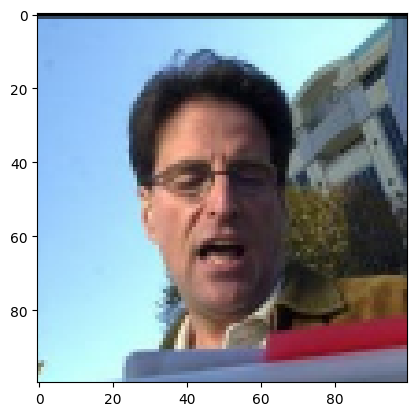

In [16]:
plt.imshow(example[1])

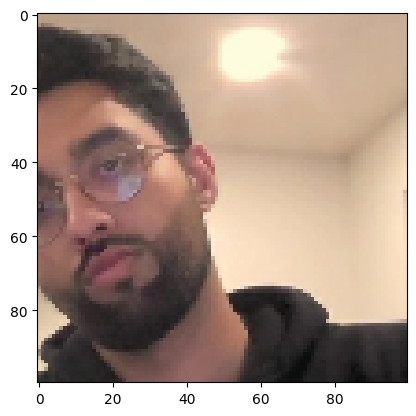

In [17]:
plt.imshow(example[0])

In [18]:
#Training Partition
#Splitting the dataset into a training partition
train_data = data.take(round(len(data) * 0.7))  # Take the first 70% of the dataset
# Selects the first 70% of the dataset by calculating and rounding 70% of its length.

#Grouping the training data into batches
train_data = train_data.batch(16)  # Group data into batches of 16
# Divides the training data into mini-batches of size 16 for efficient processing during training.

#Preloading data to avoid delays
train_data = train_data.prefetch(8)  # Preload the next 8 batches during processing
# Ensures the next 8 batches are loaded in memory while the current batch is being trained on.
# Prevents delays caused by data loading.

                       

In [19]:
#Testing partition 

# Skip the first 70% of the dataset to exclude training data
test_data = data.skip(round(len(data) * 0.7))

# Take the next 30% of the dataset for testing purposes
test_data = test_data.take(round(len(data) * 0.3))

#Grouping the training data into batches
test_data = test_data.batch(16) 


In [20]:
# Building Embedding Layer (Feature Extraction)

# Reference for embedding layer: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_img')  # Input image of size 100x100 with 3 channels (RGB)
    
    # First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)  # Convolution: Extract features using 64 filters of size 10x10
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)  # MaxPooling: Down-sample by selecting max value in 2x2 regions
    
    # Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)    # Convolution: Extract deeper features with 128 filters of size 7x7
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)  # MaxPooling: Further down-sample to reduce spatial dimensions
    
    # Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)    # Convolution: Extract even deeper features with 128 filters of size 4x4
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)  # MaxPooling: Further reduce feature map size
    
    # Final Embedding Block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)    # Convolution: Final feature extraction with 256 filters of size 4x4
    f1 = Flatten()(c4)                                 # Flatten: Convert 2D feature maps into a 1D vector for the dense layer
    d1 = Dense(4096, activation='sigmoid')(f1)         # Fully Connected Layer:
                                                       # - Reduces the extracted features to a 4096-dimensional vector
                                                       # - Sigmoid: Normalizes each value in the output vector to the range [0, 1]

    return Model(inputs=[inp], outputs=[d1], name='EmbeddingLayers')  # Return the embedding model


In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()


Model: "EmbeddingLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)               │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Building Siamese L1 Distence Class
# Custom layer for calculating L1 distance
class L1Dist(Layer):  # Inherit from TensorFlow's Layer class to make this a custom layer
    def __init__(self, **kwargs):  
        super().__init__()  # Initialize the parent Layer class to set up TensorFlow layer properties

    #similarity calculation
    def call(self, input_embedding, validation_embedding):  
         # Ensures inputs are tensors and computes the absolute difference (L1 distance)
        input_embedding = tf.convert_to_tensor(input_embedding)  # Convert to tensor if not already
        validation_embedding = tf.convert_to_tensor(validation_embedding)  # Convert to tensor
        distance = tf.math.abs(input_embedding - validation_embedding)  # Compute L1 distance
        return distance

In [24]:
#Making the Siamese Model

def make_siamese_model():
    # Anchor image input in network
    input_image = Input(name='input_img', shape=(100,100,3))  # Input layer for the anchor image (RGB, size 100x100)

    # Validation image input in network
    validation_image = Input(name='validation_img', shape=(100,100,3))  # Input layer for the validation image (RGB, size 100x100)

    # Combine Siamese distance components
    siamese_layer = L1Dist()  # Initialize the custom L1 distance layer
    siamese_layer._name = 'distance'  # Set a name for the custom layer
    distances = siamese_layer(embedding(input_image), embedding(validation_image))  # Compute L1 distance between embeddings

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)  # Predict similarity (0 to 1) using a Dense layer with sigmoid activation

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')  


In [25]:
siamese_model = make_siamese_model()

In [26]:
siamese_model.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ EmbeddingLayers (Functional)  │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist (L1Dist)              │ (1, None, 4096)           │               0 │ EmbeddingLayers[0][0],     │
│                               │                           │                 │ EmbeddingLayers[1][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#Training Process!!!!

In [28]:
# Setting up Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()  # Loss function: Measures prediction error for binary labels (similar or different)
opt = tf.keras.optimizers.Adam(0.0001)  # Optimizer: Adjusts model weights to minimize the loss using the Adam optimization algorithm


In [29]:
# Establish Checkpoints
checkpoint_dir = './training_checkpoints'  # Directory to save training progress
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')  # Checkpoint file naming convention
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)  # Tracks optimizer and model states for saving/restoring training progress

In [30]:
test_batch = train_data.as_numpy_iterator()

In [31]:
batch1 = test_batch.next()

In [32]:
batch1[2]


array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [33]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Extract inputs and labels from the batch
        input_image, validation_image = batch[0], batch[1]
        y = tf.expand_dims(batch[2], axis=-1)  # Ensure labels have shape (batch_size, 1)

        # Debug prints for shape inspection
        #tf.print("Input image shape:", tf.shape(input_image))  # Check shape of input images
       # tf.print("Validation image shape:", tf.shape(validation_image))  # Check shape of validation images
       # tf.print("Label shape:", tf.shape(y))  # Check shape of labels

        # Map inputs to the correct model input names
        inputs = {
            "input_img": input_image,  # Ensure matches with `siamese_model.input_names`
            "validation_img": validation_image
        }

        # Forward pass
        yhat = siamese_model(inputs, training=True)  # Pass inputs as a dictionary
        yhat = tf.reshape(yhat, (-1, 1))  # Match shape of predictions with labels

        # Debug print for predictions
       # tf.print("Predictions shape:", tf.shape(yhat))  # Check shape of predictions

        # Compute loss
        loss = binary_cross_loss(y, yhat)
        #tf.print("Loss:", loss)  # Print the computed loss

    # Backpropagation
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss


In [34]:
# Building training loop
def train(data, EPOCHS):  
    # Loop through epochs (complete passes through the training dataset)
    for epoch in range(1, EPOCHS + 1):  
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))  # Display the current epoch (1-based index)

        # Initialize a progress bar to show training progress within the epoch
        progbar = tf.keras.utils.Progbar(len(data))  # Progress bar tracks the number of batches processed

        # Loop through each batch in the training data
        for idx, batch in enumerate(data):  # `enumerate` provides both the batch index (idx) and batch data
            train_step(batch)  # Call the train_step function to perform a single training step on the current batch
            progbar.update(idx + 1)  # Update the progress bar to reflect completed batches

        # Save the model and optimizer states as a checkpoint every 10 epochs
        if epoch % 10 == 0:  # Check if the current epoch is a multiple of 10
            checkpoint.save(file_prefix=checkpoint_prefix)  # Save the model state to a checkpoint file


In [35]:
#Training the model itself 
EPOCHS = 50 

In [43]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 809ms/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 845ms/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 841ms/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 865ms/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 899ms/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 902ms/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 882ms/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 817ms/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 878ms/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 909ms/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 956ms/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 981ms/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 981ms/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 981ms/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 860ms/step

 Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 832ms/step

 Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 850ms/step

 Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 895ms/step



In [36]:
###TESTING NOW

#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [37]:
#Getting batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [38]:
# Make predictions
inputs = {
    "input_img": test_input,  # Match the name of the input layer for anchor images
    "validation_img": test_val  # Match the name of the input layer for validation images
}
y_hat = siamese_model.predict(inputs)
y_hat

C:\Users\hasah\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_img']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


array([[[0.49956715],
        [0.5003784 ],
        [0.500488  ],
        [0.50002855],
        [0.50015414],
        [0.50034106],
        [0.50154686],
        [0.5004492 ],
        [0.5000342 ],
        [0.4996116 ],
        [0.50107205],
        [0.50024664],
        [0.49985188],
        [0.5005717 ],
        [0.50018287],
        [0.50192297]]], dtype=float32)

In [73]:
#post processing the results 
res=[]
for prediction in y_hat.flatten():
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)

In [74]:
res

[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]

In [75]:
y_true


array([[1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [76]:
# Creating metric object
m = Recall()

#calculating the recall value
m.update_state(y_true, y_hat)

#returning recall result
m.result().numpy()

np.float32(0.71428573)

In [77]:
# Creating metric object
m = Precision()

#calculating the recall value
m.update_state(y_true, y_hat)

#returning recall result
m.result().numpy()

np.float32(0.3846154)

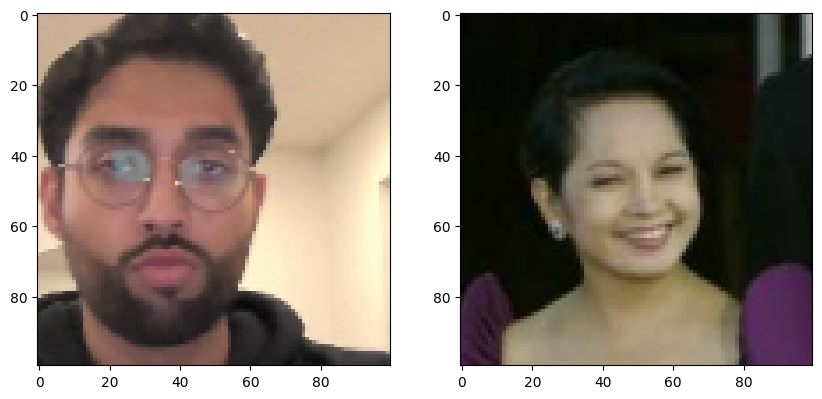

In [82]:
#vizualizing results
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1) #(row, column, index)
plt.imshow(test_input[5])
plt.subplot(1,2,2)
plt.imshow(test_val[5])

In [70]:
#Exporting Model

#saving model weights
siamese_model.save('siamesemodel.h5')


In [70]:
#reload model (need custom objest since we have a cistom layer)
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [71]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


array([[[8.8168228e-01],
        [1.5034404e-07],
        [4.6224347e-08],
        [9.9999762e-01],
        [9.9789667e-01],
        [1.6631638e-09],
        [1.5201277e-08],
        [4.4574925e-05],
        [9.9733663e-01],
        [9.9998581e-01],
        [1.0000000e+00],
        [2.6524135e-11],
        [5.8726441e-09],
        [2.3162372e-07],
        [1.0000000e+00],
        [6.1761862e-09]]], dtype=float32)

In [72]:
model.summary()


Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ EmbeddingLayers (Functional)  │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (1, None, 4096)           │               0 │ EmbeddingLayers[0][0],     │
│                               │                           │                 │ EmbeddingLayers[1][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Real-Time Test
# Verification Function: Uses OpenCV to access the webcam for input images.
# - The verification process compares input images against positive samples.
# - Loops through the verification process 50 times to ensure accuracy.
# - Each prediction result is a value between 0 and 1.
# - Two functions, `verification_threshold` and `detection_threshold`, compute the final prediction.
# Detection Threshold: Metric above which a prediction is considered positive
# Verification Threshold: Proportion of positive predictions / total positive samples
# 
# Instructions for setup:
# 1. Create a directory named application_data.
# 2. Inside application_data, create two subdirectories: verification_images and input_image.
# 3. In the verification_images directory, copy 50 random images from the positive samples folder.
#    - Note: You can use more images for better accuracy, but this may slow down the verification process.


In [92]:
# Verification Function

def verify(model, detection_threshold, verification_threshold):
    # List to store prediction results
    results = []

    # Loop through all images in the verification_images directory
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        # Preprocess the input image (anchor image) for the model
        # 'input_image.jpg' is the file that contains the frame to be verified
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        
        # Preprocess each validation image (images we compare the input to)
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Expand dimensions to match the model's expected input shape
        # np.expand_dims([input_img, validation_img], axis=1):
        #   - Combines input_img and validation_img into a list of two tensors.
        #   - Expands the dimension of the list to add an extra dimension at axis 1
        # list(): Ensures the data is in list format for the model input
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        
        # Append the prediction result to the results list
        results.append(result)

    #Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    #Verification Threshold: Proportion of positive predictions/total positive samples
    verified = verification > verification_threshold # true or false value will be stored in verified

    return results, verified


In [93]:
# OpenCV Integration
cap = cv2.VideoCapture(0)  # Connect to the webcam; index 0 refers to the default webcam
while cap.isOpened():  # Loop as long as the webcam connection is open
    # Capture frames from the webcam
    ret, frame = cap.read()  # cap.read() reads a frame from the webcam
    # - 'ret': Boolean indicating if the frame was successfully captured
    # - 'frame': The actual image data (a NumPy array)

    # Flip the frame horizontally and resize the image to 250 x 250
    frame = cv2.flip(frame, 1)  # Flip around the vertical axis (1 for horizontal flip)
    frame = frame[120:120 + 250, 200:200 + 250, :]  # Only capture the center 250x250 pixels

    # Display the captured frame
    cv2.imshow('Verification', frame)  # Open a window to display the current frame

    # Verification trigger
    if cv2.waitKey(1) & 0xFF == ord('v'):
        # Save input image to 'application_data/input_image' folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        
        # Print access status based on verification result
        if verified:
            print("Access Granted")
        else:
            print("Access Denied")

    # Break out of the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources and close OpenCV windows
cap.release()  # Release the webcam resource
cv2.destroyAllWindows()  # Close all OpenCV windows


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms